# Posterior inference on a simple birth-death model

In [1]:
from gcdyn import models, mutators, poisson, utils
from scipy.stats import gamma, lognorm, norm
from functools import partial
import numpy as np
import seaborn as sns
from mcmc import mh_tour
from jax import jit
from jax.config import config
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

## Set up truth

In [2]:
seed = 10

# (Deliberately avoiding rate parameters == constant 1, because a lot of bugs hide in this scenario)
true_parameters = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 2.0, 0.5),
    "death_response": poisson.ConstantResponse(1.3),
    "mutation_response": poisson.ConstantResponse(1.2),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5, 7, 9),
        transition_matrix=np.array(
            [
                [3, 2, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [1, 2, 3, 2, 1],
                [1, 1, 2, 3, 2],
                [1, 1, 2, 2, 3],
            ]
        )
        / 9,
    ),
    "extant_sampling_probability": 1,
}

PRESENT_TIME = 5

trees = utils.sample_trees(n=4, t=PRESENT_TIME, init_x=1, **true_parameters, seed=seed)

for tree in trees:
    tree._pruned = True
# to let σ=1

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 48 times.
Success: average of 346.75 nodes per tree, over 4 trees.


## Configure priors and proposals

In [3]:
sampled_parameters = {
    "xscale": {
        "prior": gamma(a=2, scale=1),
        "proposal": lambda current: lognorm(scale=current, s=3),
    },
    "xshift": {
        "prior": norm(loc=5, scale=1),
        "proposal": lambda current: norm(loc=current, scale=2),
    },
    "yscale": {
        "prior": gamma(a=2, scale=1),
        "proposal": lambda current: lognorm(scale=current, s=1),
    },
    "yshift": {
        "prior": gamma(a=1, scale=1 / 2),
        "proposal": lambda current: lognorm(scale=current, s=1),
    },
    "death_rate_value": {
        "prior": gamma(a=3.5, scale=1 / 3),
        "proposal": lambda current: lognorm(scale=current, s=0.5),
    },
}

## Configure likelihood

In [4]:
log_likelihood_base = jit(
    partial(
        models.stadler_appx_log_likelihood,
        trees=trees,
        mutation_response=true_parameters["mutation_response"],
        mutator=true_parameters["mutator"],
        extant_sampling_probability=true_parameters["extant_sampling_probability"],
        extinct_sampling_probability=1,
        present_time=PRESENT_TIME,
    )
)


def log_likelihood(death_rate_value, **birth_params):
    birth_response = poisson.SigmoidResponse(**birth_params)
    death_response = poisson.ConstantResponse(death_rate_value)

    return log_likelihood_base(
        birth_response=birth_response,
        death_response=death_response,
    )

## Prior samples and means

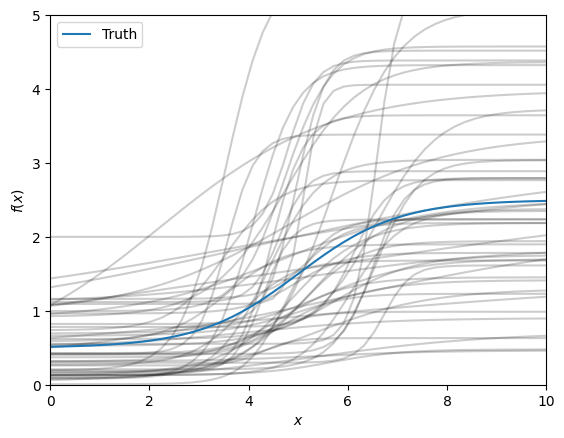

In [5]:
prior_samples = {
    param: config["prior"].rvs(size=1000)
    for param, config in sampled_parameters.items()
}

birth_prior_samples = []

for i in range(len(prior_samples["xscale"])):
    response = poisson.SigmoidResponse(
        xscale=prior_samples["xscale"][i].item(),
        xshift=prior_samples["xshift"][i].item(),
        yscale=prior_samples["yscale"][i].item(),
        yshift=prior_samples["yshift"][i].item(),
    )

    birth_prior_samples.append(response)

x_array = np.linspace(0, 10)

plt.figure()

for response in birth_prior_samples[-50:]:
    plt.plot(x_array, response.λ_phenotype(x_array), color="black", alpha=0.2)


plt.plot(x_array, true_parameters["birth_response"].λ_phenotype(x_array), label="Truth")

plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 10)
plt.ylim(0, 5)
plt.legend()

plt.show()

In [6]:
{param: s.mean() for param, s in prior_samples.items()}

{'xscale': 1.9854285679392454,
 'xshift': 5.080612796671776,
 'yscale': 1.9599070840928257,
 'yshift': 0.5132910572590947,
 'death_rate_value': 1.158729379418591}

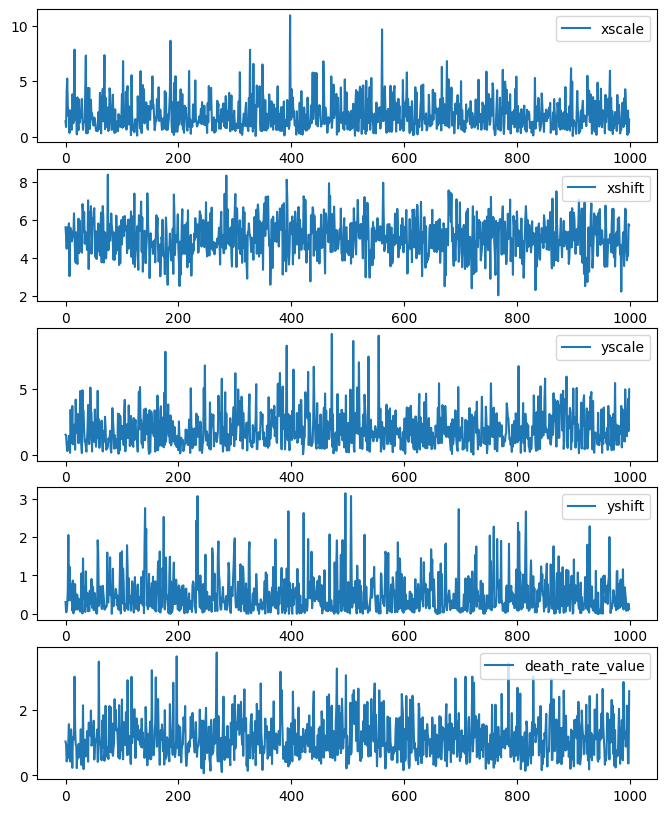

In [7]:
fig, axes = plt.subplots(5, 1)
fig.set_figwidth(8)
fig.set_figheight(10)

for ax, param in zip(axes, prior_samples):
    sns.lineplot({param: prior_samples[param]}, ax=ax)

plt.show()

## Run MCMC

In [8]:
samples = mh_tour(
    num_samples=1000,
    initial_value={
        "xscale": true_parameters["birth_response"].xscale,
        "xshift": true_parameters["birth_response"].xshift,
        "yscale": true_parameters["birth_response"].yscale,
        "yshift": true_parameters["birth_response"].yshift,
        "death_rate_value": 2,
    },
    log_priors={
        param: (lambda θ: config["prior"].logpdf(θ))
        for param, config in sampled_parameters.items()
    },
    log_likelihood=log_likelihood,
    proposal_generators={
        param: (lambda current: config["proposal"](current).rvs(size=1).item())
        for param, config in sampled_parameters.items()
    },
    proposal_log_densities={
        param: (lambda prop, cur: config["proposal"](cur).logpdf(prop))
        for param, config in sampled_parameters.items()
    },
)

  0%|          | 0/1000 [00:00<?, ?it/s]

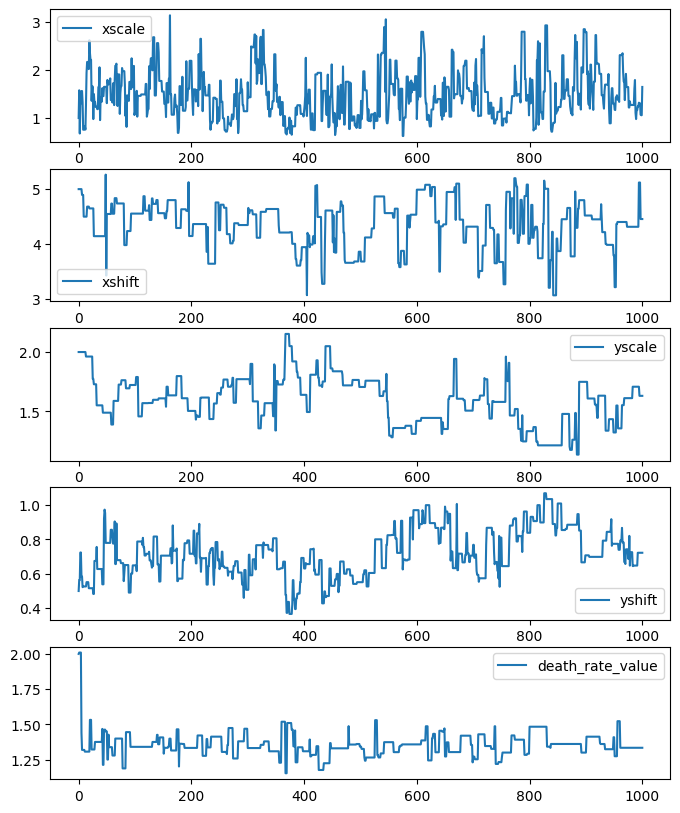

In [14]:
fig, axes = plt.subplots(5, 1)
fig.set_figwidth(8)
fig.set_figheight(10)

for ax, param in zip(axes, samples):
    sns.lineplot({param: samples[param]}, ax=ax)

plt.show()

In [15]:
for param, chain in samples.items():
    acceptance_ratio = np.mean(chain[:-1] != chain[1:])
    print(f"Accepted {acceptance_ratio*100}% of {param} proposals")

Accepted 54.900000000000006% of xscale proposals
Accepted 18.5% of xshift proposals
Accepted 14.000000000000002% of yscale proposals
Accepted 26.8% of yshift proposals
Accepted 12.8% of death_rate_value proposals


## Posterior samples and means

In [16]:
birth_samples = []

for i in range(len(samples["xscale"])):
    response = poisson.SigmoidResponse(
        xscale=samples["xscale"][i].item(),
        xshift=samples["xshift"][i].item(),
        yscale=samples["yscale"][i].item(),
        yshift=samples["yshift"][i].item(),
    )

    birth_samples.append(response)

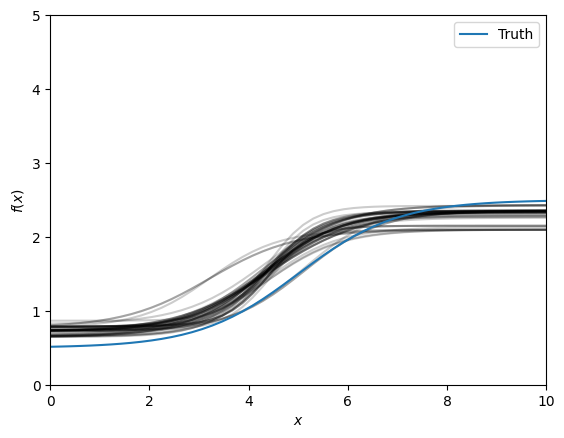

In [17]:
x_array = np.linspace(0, 10)

plt.figure()

for response in birth_samples[-50:]:
    plt.plot(x_array, response.λ_phenotype(x_array), color="black", alpha=0.2)


plt.plot(x_array, true_parameters["birth_response"].λ_phenotype(x_array), label="Truth")

plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, 10)
plt.ylim(0, 5)
plt.legend()

plt.show()

In [13]:
{param: s.mean() for param, s in samples.items()}

{'xscale': 1.4983283171063664,
 'xshift': 4.360745720566009,
 'yscale': 1.5934245139237215,
 'yshift': 0.7199985286780739,
 'death_rate_value': 1.3556101928606181}